In [5]:
import json
import os
import sys
import pickle
import re

import numpy as np
import pandas as pd
import sys
sys.path.append('../..')
from networks import DualNet, DualNetEndToEnd, PrimalNet, PrimalNetEndToEnd, PrimalNetEndToEnd, DualClassificationNetEndToEnd
import torch

def evaluate(data, primal_net, test_indices):        
    X = data.X[test_indices]
    # X = add_zeros(data, X, 0.01)

    Y_target = data.opt_targets["y_operational"][test_indices]
    
    # Forward pass through networks
    Y = primal_net(X)

    ineq_dist = data.relative_ineq_dist(X, Y)
    eq_resid = data.relative_eq_resid(X, Y)

    # Convert lists to arrays for easier handling
    obj_values = data.obj_fn(X, Y).detach().numpy()
    ineq_max_vals = torch.max(ineq_dist, dim=1)[0].detach().numpy() # First element is the max, second is the index
    ineq_mean_vals = torch.mean(ineq_dist, dim=1).detach().numpy()
    eq_max_vals = torch.max(torch.abs(eq_resid), dim=1)[0].detach().numpy() # First element is the max, second is the index
    eq_mean_vals = torch.mean(torch.abs(eq_resid), dim=1).detach().numpy()
    known_obj = data.obj_fn(X, Y_target).detach().numpy()
    # obj_values is negative
    opt_gap = (obj_values - known_obj)/np.abs(known_obj) * 100

    return np.mean(obj_values), np.mean(known_obj), np.mean(opt_gap), np.mean(ineq_max_vals), np.mean(ineq_mean_vals), np.mean(eq_max_vals), np.mean(eq_mean_vals)

def calc_duality_gap(data, primal_net, dual_net):
    X = data.X[test_indices]
    # X = add_zeros(data, X, 0.01)

    Y_target = data.opt_targets["y_operational"][test_indices]
    
    # Forward pass through networks
    Y = primal_net(X)
    obj_values = data.obj_fn(X, Y).detach().numpy()

    mu, lamb = dual_net(X)
    dual_obj_values = data.dual_obj_fn(X, mu, lamb).detach().numpy()

    duality_gap = (obj_values - dual_obj_values) / np.abs(obj_values) * 100

    return np.mean(duality_gap)

def dual_evaluate(data, dual_net, test_indices):
    X = data.X[test_indices]
    # X = add_zeros(data, X, 0.01)
    # target_mu = data.mu[test_indices]
    # target_lamb = data.lamb[test_indices]
    target_mu = data.opt_targets["mu_operational"][test_indices]  
    target_lamb = data.opt_targets["lamb_operational"][test_indices]

    # Forward pass through networks
    mu, lamb = dual_net(X)

    obj_values = data.dual_obj_fn(X, mu, lamb).detach().numpy()
    known_obj = data.dual_obj_fn(X, target_mu, target_lamb).detach().numpy()
    # dual_ineq_dist = data.dual_ineq_dist(mu, lamb)
    dual_ineq_resid = data.dual_ineq_resid(mu, lamb)
    dual_ineq_dist = torch.clamp(dual_ineq_resid, 0)
    dual_eq_resid = data.dual_eq_resid(mu, lamb)

    opt_gap = (obj_values - known_obj)/np.abs(known_obj) * 100

    classes = target_lamb.unique(dim=0).detach().numpy()
    # Convert to NumPy for indexing
    target_lamb_np = target_lamb.detach().cpu().numpy()

    opt_gap_classes = []
    counts = []
    for c in classes:
        # Find rows in target_lamb that match class c
        matches = np.all(target_lamb_np == c, axis=1)
        indices = np.where(matches)[0]

        mean_gap = np.mean(opt_gap[indices])
        opt_gap_classes.append(mean_gap)

        print(f"Class {c}: {mean_gap:.4f}")
        print(f"Count: {len(indices)}")
        print(f"Known obj mean: {known_obj[indices].mean()}")
        counts.append(len(indices))
        print("-"*40)
    print(sum(counts))

    # import matplotlib.pyplot as plt
    # plt.hist(opt_gap, bins=50)
    # plt.title("Optimality Gaps (%)")
    # plt.show()

    ineq_max_vals = torch.max(dual_ineq_dist, dim=1)[0].detach().numpy() # First element is the max, second is the index
    eq_max_vals = torch.max(torch.abs(dual_eq_resid), dim=1)[0].detach().numpy() # First element is the max, second is the index
    ineq_mean_vals = torch.mean(dual_ineq_dist, dim=1).detach().numpy()
    eq_mean_vals = torch.mean(torch.abs(dual_eq_resid), dim=1).detach().numpy()

    return np.mean(obj_values), np.mean(known_obj), np.mean(opt_gap), np.mean(ineq_max_vals), np.mean(ineq_mean_vals), np.mean(eq_max_vals), np.mean(eq_mean_vals)

repeats = 5
stats_dict = {}

# args = json.load(open('config.json'))
#data_path = "experiment-output/ch7/3nodes/training_data/ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"
data_path = "3nodes/training_data/ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl"
# data_path = "data/ED_data/ED_NB-G_GB1-G1_L1_c0_s0_p0_smp15.pkl"
# print me the working directory

data = pickle.load(open(data_path, 'rb'))

indices = torch.arange(data.X.shape[0])

for run, (path, name) in enumerate(zip([
            "./3nodes/primal_model",
            "./3nodes/dual_model"
            # "experiment-output/ch6/repair-2/learn_primal:True_train:0.8_rho:0.5_rhomax:5000_alpha:10_L:10-1746434902-974866"
            ],
            [
                "primal",
                "dual"
            ])):
    stats_dict[name] = {"predicted_obj": [], "known_obj": [], "opt_gap": [], "ineq_max": [], "ineq_mean": [], "eq_max": [], "eq_mean": []}
    with open(os.path.join(path, 'args.json'), 'r') as f:
        args = json.load(f)
    # with open('config.json', 'r') as f:
    #     args = json.load(f)

    optuna_args = {'primal_lr': 0.0006785456069117277, 'hidden_size_factor': 28, 'n_layers': 2, 'decay': 0.9989743016070536, 'batch_size': 2048}
    # dual_optuna_args = {'dual_lr': 0.0005526546726343357, 'hidden_size_factor': 23, 'n_layers': 6, 'decay': 0.9877971362082678, 'batch_size': 2048}

    if run == 0:
        args["primal_lr"] = optuna_args["primal_lr"]
        args["hidden_size_factor"] = optuna_args["hidden_size_factor"]
        args["n_layers"] = optuna_args["n_layers"]
        args["decay"] = optuna_args["decay"]
        args["batch_size"] = optuna_args["batch_size"]
        primal_net = PrimalNetEndToEnd(args, data=data)
        primal_net.load_state_dict(torch.load(os.path.join(path, 'primal_weights.pth'), weights_only=True))
        primal_net.eval()
    
    if run == 1:
    #     args["dual_lr"] = dual_optuna_args["dual_lr"]
    #     args["hidden_size_factor"] = dual_optuna_args["hidden_size_factor"]
    #     args["n_layers"] = dual_optuna_args["n_layers"]
    #     args["decay"] = dual_optuna_args["decay"]
    #     args["batch_size"] = dual_optuna_args["batch_size"]
        if args["dual_classification"]:
            dual_net = DualClassificationNetEndToEnd(args, data=data)
        else:
            dual_net = DualNetEndToEnd(args, data=data)
        dual_net.load_state_dict(torch.load(os.path.join(path, 'dual_weights.pth'), weights_only=True))
        dual_net.eval()

    # Compute sizes for each set
    train_size = int(args["train"] * data.X.shape[0])
    valid_size = int(args["valid"] * data.X.shape[0])
    # print(f"Train size: {train_size}, Valid size: {valid_size}, Test size: {data.X.shape[0] - train_size - valid_size}")


    # Split the indices
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size+valid_size]
    test_indices = indices[train_size+valid_size:]

    # for i, repeat in enumerate(range(repeats)):
        
    # directory = os.path.join(path, f"repeat:{repeat}")
    # directory = f"experiment-output/ch5-reproduction-nonconvex/{experiment}/repeat:{repeat}"
    # dual_net = DualNet(args, data=data)
    # dual_net.load_state_dict(torch.load(os.path.join(directory, 'dual_weights.pth'), weights_only=True))

    # obj_val, known_obj, opt_gap, ineq_max, ineq_mean, eq_max, eq_mean = dual_evaluate(data, dual_net, test_indices)
    if run == 0:
        obj_val, known_obj, opt_gap, ineq_max, ineq_mean, eq_max, eq_mean = evaluate(data, primal_net, test_indices)
    if run == 1:
        obj_val, known_obj, opt_gap, ineq_max, ineq_mean, eq_max, eq_mean = dual_evaluate(data, dual_net, test_indices)
    stats_dict[name]["predicted_obj"].append(obj_val)
    stats_dict[name]["known_obj"].append(known_obj)
    stats_dict[name]["opt_gap"].append(opt_gap)
    stats_dict[name]["ineq_max"].append(ineq_max)
    stats_dict[name]["ineq_mean"].append(ineq_mean)
    stats_dict[name]["eq_max"].append(eq_max)
    stats_dict[name]["eq_mean"].append(eq_mean)

    duality_gap = calc_duality_gap(data, primal_net, dual_net)

    print(duality_gap)


stats_dict

        

NameError: name 'dual_net' is not defined

In [3]:
!pwd

/Users/peterhuang/Desktop/Delft/Year-2/masterthesis/experiment-output/ch7


In [6]:
!ls 3nodes/benders_data/

X.pkl
Y.pkl
dual_solutions.pkl
experiment_data_sample_duration:120_start_exact:False_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:False_exact_refinement:True_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:True_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
objs.pkl
primal_solutions.pkl


In [10]:
# Prepare final summary for LaTeX export
summary = {
    "Experiment": [],
    "Optimal Obj": [],
    "Predicted Obj": [],
    "OptGap (\%)": [],
    "IneqMax": [],
    "IneqMean": [],
    "EqMax": [],
    "EqMean": [],
}

for experiment, metrics in stats_dict.items():
    summary["Experiment"].append(experiment)
    summary["Optimal Obj"].append(f"{np.mean(metrics['known_obj']):.3f}")
    summary["Predicted Obj"].append(f"{np.mean(metrics['predicted_obj']):.3f}({np.std(metrics['predicted_obj']):.3f})")
    summary["OptGap (\%)"].append(
        f"{np.mean(metrics['opt_gap']):.3f}({np.std(metrics['opt_gap']):.3f})"
    )
    summary["IneqMax"].append(
        f"{np.mean(metrics['ineq_max']):.3f}({np.std(metrics['ineq_max']):.3f})"
    )
    summary["IneqMean"].append(
        f"{np.mean(metrics['ineq_mean']):.3f}({np.std(metrics['ineq_mean']):.3f})"
    )
    summary["EqMax"].append(
        f"{np.mean(metrics['eq_max']):.3f}({np.std(metrics['eq_max']):.3f})"
    )
    summary["EqMean"].append(
        f"{np.mean(metrics['eq_mean']):.3f}({np.std(metrics['eq_mean']):.3f})"
    )

df = pd.DataFrame(summary)

# For LaTeX export
latex_table = df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{rrrrrrrr}
\toprule
Experiment & Optimal Obj & Predicted Obj & OptGap (\%) & IneqMax & IneqMean & EqMax & EqMean \\
\midrule
\bottomrule
\end{tabular}



# Benders table

In [12]:
import pandas as pd

exact_path = "3nodes/benders_data/experiment_data_sample_duration:120_start_exact:True_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"
inexact_path = "3nodes/benders_data/experiment_data_sample_duration:120_start_exact:False_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"
exact_refinement_path = "3nodes/benders_data/experiment_data_sample_duration:120_start_exact:False_exact_refinement:True_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"

df_exact = pd.read_csv(exact_path)
df_inexact = pd.read_csv(inexact_path)
df_exact_refinement = pd.read_csv(exact_refinement_path)

df_exact

,repeat,sample,opt_obj,upper_bound,lower_bound,total_iterations,exact_iterations,inexact_iterations,total_time,total_time_master,total_time_subproblem_exact,total_time_subproblem_pdl,investments
0,0,0,2.604709e+07,2.604709e+07,2.604709e+07,41,41,0,0.555285,0.214840,0.340445,0,"[86.0, 1.0, 254.0, -0.0, 62.0, -0.0]"
1,0,1,3.128342e+07,3.128342e+07,3.128342e+07,40,40,0,0.476187,0.162153,0.314034,0,"[100.0, -0.0, 234.0, -0.0, 68.0, -0.0]"
2,0,2,3.085474e+07,3.085474e+07,3.085474e+07,47,47,0,0.710045,0.331818,0.378227,0,"[102.0, -0.0, 247.0, -0.0, 61.0, -0.0]"
3,0,3,3.177877e+07,3.177877e+07,3.177877e+07,49,49,0,0.731115,0.314469,0.416645,0,"[83.0, 12.0, 256.0, -0.0, 70.0, -0.0]"
4,0,4,3.300652e+07,3.300652e+07,3.300652e+07,56,56,0,0.802800,0.337480,0.465320,0,"[90.0, 14.0, 251.0, -0.0, 73.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,4,68,3.195342e+07,3.195342e+07,3.195342e+07,40,40,0,0.639060,0.267303,0.371758,0,"[122.0, -0.0, 249.0, -0.0, 59.0, -0.0]"
361,4,69,2.962280e+07,2.962280e+07,2.962280e+07,42,42,0,0.628907,0.284464,0.344443,0,"[99.0, -0.0, 256.0, -0.0, 60.0, -0.0]"
362,4,70,2.624133e+07,2.624133e+07,2.624133e+07,44,44,0,0.695925,0.308187,0.387738,0,"[76.0, -0.0, 233.0, -0.0, 54.0, -0.0]"
363,4,71,2.188967e+07,2.188967e+07,2.188967e+07,44,44,0,0.557214,0.204114,0.353100,0,"[107.0, -0.0, 205.0, -0.0, 46.0, 0.0]"


In [13]:

metrics = [
    ("upper_bound", "Upper bound"),
    ("lower_bound", "Lower bound"),
    ("duality_gap", "Duality gap (\%)"),
    ("total_iterations", "Total Iterations"),
    ("exact_iterations", "Exact Iterations"),
    ("inexact_iterations", "Inexact Iterations"),
    ("total_time_master", "Total time master problem (s)"),
    ("total_time_subproblem_exact", "Total time subproblem (exact) (s)"),
    ("total_time_subproblem_pdl", "Total time subproblem (PDL) (s)"),
    ("total_time", "Total time (s)"),
    ("time_per_iteration", "Time per iteration (s)"),
]

# # Add duality gap and time per iteration columns if not present
# for df in [df_exact, df_inexact, df_exact_refinement]:
#     if "duality_gap" not in df.columns:
#         df["duality_gap"] = (df["upper_bound"] - df["lower_bound"]) / df["upper_bound"] * 100
#     if "time_per_iteration" not in df.columns:
#         df["time_per_iteration"] = df["total_time"] / df["total_iterations"].abs()

def mean_std(series, floatfmt="{:.3f}"):
    return f"{floatfmt.format(series.mean())} ({floatfmt.format(series.std())})"

def make_summary_table(dfs, metrics):
    summary = []
    for col, label in metrics:
        row = [label]
        for df in dfs:
            # Use 2 decimals for most, 4 for times
            if "time" in col or "duality_gap" in col:
                fmt = "{:.3f}"
            else:
                fmt = "{:.3f}"
            row.append(mean_std(df[col], floatfmt=fmt))
        summary.append(row)
    return pd.DataFrame(
        summary,
        columns=["Metric", "Exact Benders", "Inexact Benders", "Inexact Benders + exact refinement"]
    )

# Group by 'sample' and take the mean over repeats for each method
df_exact_samplemean = df_exact.groupby("sample").mean(numeric_only=True).reset_index()
df_inexact_samplemean = df_inexact.groupby("sample").mean(numeric_only=True).reset_index()
df_exact_refinement_samplemean = df_exact_refinement.groupby("sample").mean(numeric_only=True).reset_index()

# Add duality gap and time per iteration columns if not present
for df in [df_exact_samplemean, df_inexact_samplemean, df_exact_refinement_samplemean]:
    if "duality_gap" not in df.columns:
        df["duality_gap"] = (df["upper_bound"] - df["lower_bound"]) / df["upper_bound"] * 100
    if "time_per_iteration" not in df.columns:
        df["time_per_iteration"] = df["total_time"] / df["total_iterations"].abs()

# Now use your existing summary table code
summary_df = make_summary_table(
    [df_exact_samplemean, df_inexact_samplemean, df_exact_refinement_samplemean],
    metrics
)
latex_table_all = summary_df.to_latex(index=False, escape=False, column_format="lccc")
print(latex_table_all)

\begin{tabular}{lccc}
\toprule
Metric & Exact Benders & Inexact Benders & Inexact Benders + exact refinement \\
\midrule
Upper bound & 22632118.400 (5895285.821) & 847552548.424 (158977269.906) & 22632118.400 (5895285.821) \\
Lower bound & 22632118.400 (5895285.821) & 5717028.754 (5343406.832) & 22632118.400 (5895285.821) \\
Duality gap (\%) & 0.000 (0.000) & 99.249 (0.919) & 0.000 (0.000) \\
Total Iterations & 74.233 (22.265) & 9.795 (3.476) & 76.863 (22.723) \\
Exact Iterations & 74.233 (22.265) & 0.000 (0.000) & 67.068 (24.185) \\
Inexact Iterations & 0.000 (0.000) & 9.795 (3.476) & 9.795 (3.476) \\
Total time master problem (s) & 0.773 (0.420) & 0.022 (0.009) & 0.822 (0.453) \\
Total time subproblem (exact) (s) & 0.645 (0.201) & 0.000 (0.000) & 0.603 (0.224) \\
Total time subproblem (PDL) (s) & 0.000 (0.000) & 0.009 (0.003) & 0.009 (0.003) \\
Total time (s) & 1.418 (0.610) & 0.032 (0.012) & 1.434 (0.666) \\
Time per iteration (s) & 0.018 (0.003) & 0.003 (0.000) & 0.018 (0.004) \\
\

In [14]:
# Find indices where upper or lower bounds differ between exact and exact refinement
diff_mask = (df_exact["upper_bound"] != df_exact_refinement["upper_bound"]) | \
            (df_exact["lower_bound"] != df_exact_refinement["lower_bound"])

# Extract the differing rows
diff_df = pd.DataFrame({
    "Index": df_exact.index[diff_mask],
    "Exact Upper": df_exact.loc[diff_mask, "upper_bound"],
    "Refinement Upper": df_exact_refinement.loc[diff_mask, "upper_bound"],
    "Exact Lower": df_exact.loc[diff_mask, "lower_bound"],
    "Refinement Lower": df_exact_refinement.loc[diff_mask, "lower_bound"]
})

# Print the results
if not diff_df.empty:
    print("Samples where upper or lower bounds differ between Exact and Inexact Benders + exact refinement:")
    print(diff_df.to_string(index=False))
else:
    print("No differences in upper or lower bounds between Exact and Inexact Benders + exact refinement.")

Samples where upper or lower bounds differ between Exact and Inexact Benders + exact refinement:
 Index  Exact Upper  Refinement Upper  Exact Lower  Refinement Lower
     6 3.268328e+07      3.268328e+07 3.268328e+07      3.268328e+07
    13 2.348922e+07      2.348922e+07 2.348922e+07      2.348922e+07
    15 2.320805e+07      2.320805e+07 2.320805e+07      2.320805e+07
    24 1.654989e+07      1.654989e+07 1.654989e+07      1.654989e+07
    28 1.542887e+07      1.542887e+07 1.542887e+07      1.542887e+07
    33 1.845259e+07      1.845259e+07 1.845259e+07      1.845259e+07
    34 1.752082e+07      1.752082e+07 1.752082e+07      1.752082e+07
    37 1.742579e+07      1.742579e+07 1.742579e+07      1.742579e+07
    42 1.465792e+07      1.465792e+07 1.465792e+07      1.465792e+07
    43 1.602848e+07      1.602848e+07 1.602848e+07      1.602848e+07
    55 2.222396e+07      2.222396e+07 2.222396e+07      2.222396e+07
    61 2.685818e+07      2.685818e+07 2.685818e+07      2.685818e+07
    79

In [15]:
import matplotlib.pyplot as plt

palette = plt.get_cmap("tab10")
point_colors = [palette(0), palette(1)]

plt.rcParams.update({
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 17,
    "font.size": 18
})

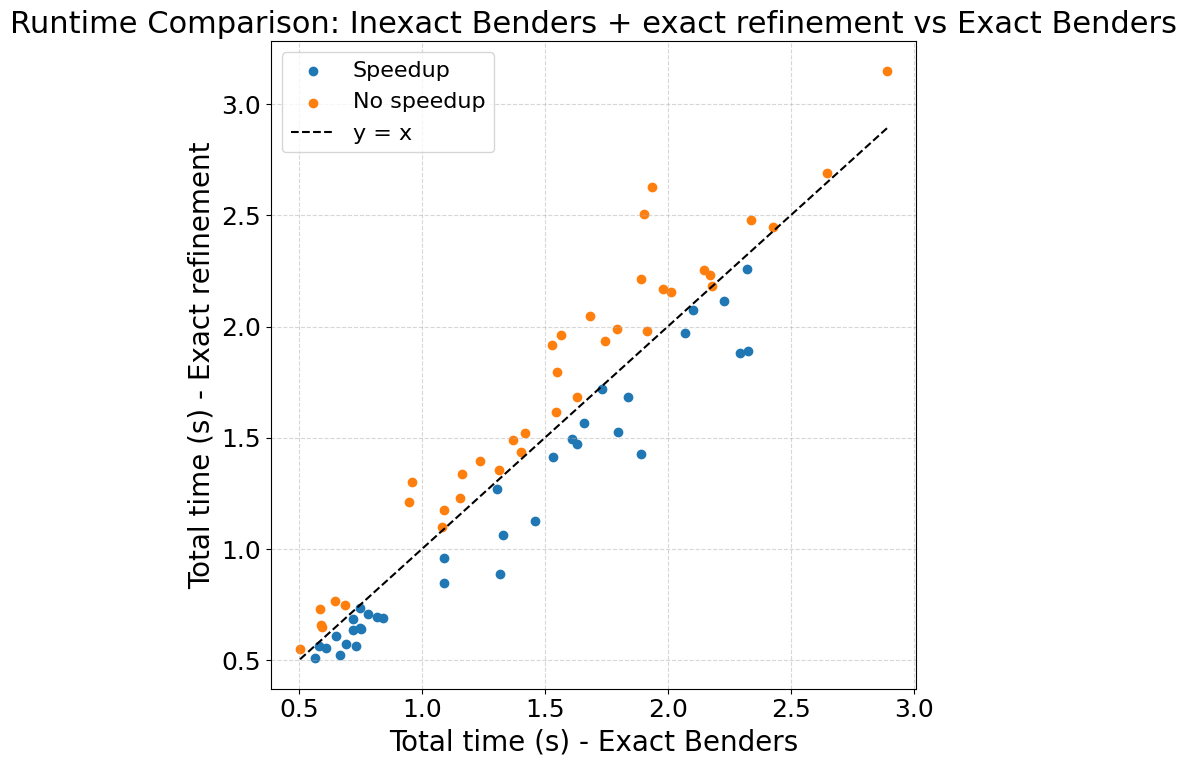

In [16]:
# Get total times
x = df_exact_samplemean["total_time"].values
y = df_exact_refinement_samplemean["total_time"].values

# Determine which are speedups
speedup = y < x

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(x[speedup], y[speedup], color=point_colors[0], label='Speedup')
plt.scatter(x[~speedup], y[~speedup], color=point_colors[1], label='No speedup')
plt.plot([min(x), max(x)], [min(x), max(x)], 'k--', label='y = x')

plt.xlabel("Total time (s) - Exact Benders")
plt.ylabel("Total time (s) - Exact refinement")
plt.title("Runtime Comparison: Inexact Benders + exact refinement vs Exact Benders")
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

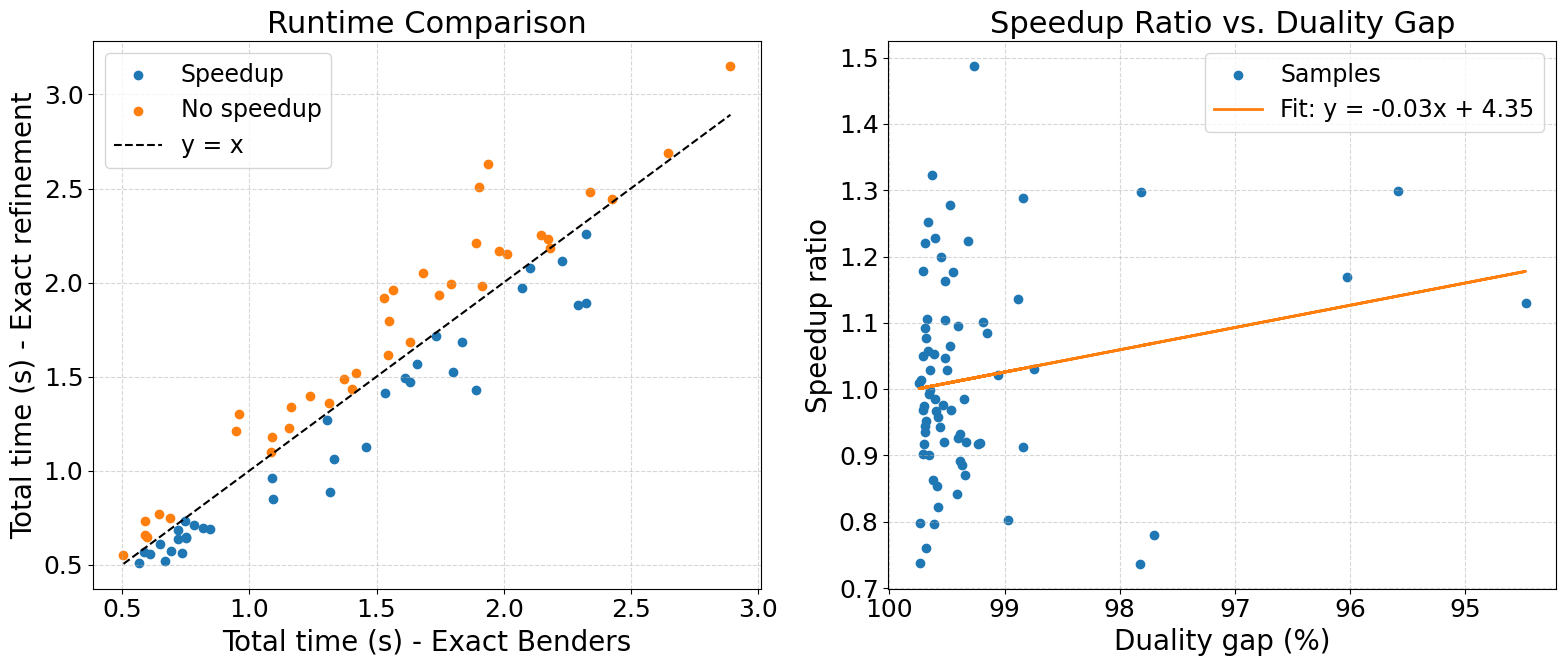

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data for first plot ---
x1 = df_exact_samplemean["total_time"].values
y1 = df_exact_refinement_samplemean["total_time"].values
speedup = y1 < x1

# --- Data for second plot ---
speedup_ratio = x1 / y1
x2 = df_inexact_samplemean["duality_gap"].values
y2 = speedup_ratio
m, b = np.polyfit(x2, y2, 1)
y2_fit = m * x2 + b

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

# --- First subplot: Runtime comparison ---
axes[0].scatter(x1[speedup], y1[speedup], color=point_colors[0], label='Speedup')
axes[0].scatter(x1[~speedup], y1[~speedup], color=point_colors[1], label='No speedup')
axes[0].plot([min(x1), max(x1)], [min(x1), max(x1)], 'k--', label='y = x')
axes[0].set_xlabel("Total time (s) - Exact Benders")
axes[0].set_ylabel("Total time (s) - Exact refinement")
axes[0].set_title("Runtime Comparison")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)
# axes[0].set_aspect('equal', adjustable='box')

# --- Second subplot: Speedup vs Duality gap ---
axes[1].scatter(x2, y2, color=point_colors[0], label="Samples")
axes[1].plot(x2, y2_fit, color=point_colors[1], linewidth=2, label=f"Fit: y = {m:.2f}x + {b:.2f}")
axes[1].set_ylabel("Speedup ratio")
axes[1].set_xlabel("Duality gap (%)")
axes[1].set_title("Speedup Ratio vs. Duality Gap")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].invert_xaxis()

plt.tight_layout()
plt.savefig("figures/ch8-benders-speedup-comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
!ls 3nodes/benders_data

X.pkl
Y.pkl
dual_solutions.pkl
experiment_data_sample_duration:120_start_exact:False_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:False_exact_refinement:False_run_name:train:0.8_rho:0.5_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:False_exact_refinement:True_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:False_exact_refinement:True_run_name:train:0.8_rho:0.5_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:True_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv
experiment_data_sample_duration:120_start_exact:True_exact_refinement:False_run_name:train:0.8_rho:0.5_rhomax:5000_alpha:10.csv
objs.pkl
primal_solutions.pkl


   sample  repeat                                       u
0       0       0    [86.0, 1.0, 254.0, -0.0, 62.0, -0.0]
1       1       0  [100.0, -0.0, 234.0, -0.0, 68.0, -0.0]
2       2       0  [102.0, -0.0, 247.0, -0.0, 61.0, -0.0]
3       3       0   [83.0, 12.0, 256.0, -0.0, 70.0, -0.0]
4       4       0    [90.0, 14.0, 251.0, -0.0, 73.0, 1.0]
   sample  repeat                                       u
0       0       0    [86.0, 1.0, 254.0, -0.0, 62.0, -0.0]
1       1       0  [100.0, -0.0, 234.0, -0.0, 68.0, -0.0]
2       2       0  [102.0, -0.0, 247.0, -0.0, 61.0, -0.0]
3       3       0   [83.0, 12.0, 256.0, -0.0, 70.0, -0.0]
4       4       0    [90.0, 14.0, 251.0, -0.0, 73.0, 1.0]
   sample  repeat                                       u
0       0       0    [86.0, 1.0, 254.0, -0.0, 62.0, -0.0]
1       1       0  [100.0, -0.0, 234.0, -0.0, 68.0, -0.0]
2       2       0  [102.0, -0.0, 247.0, -0.0, 61.0, -0.0]
3       3       0   [83.0, 12.0, 256.0, -0.0, 70.0, -0.0]
4       4     

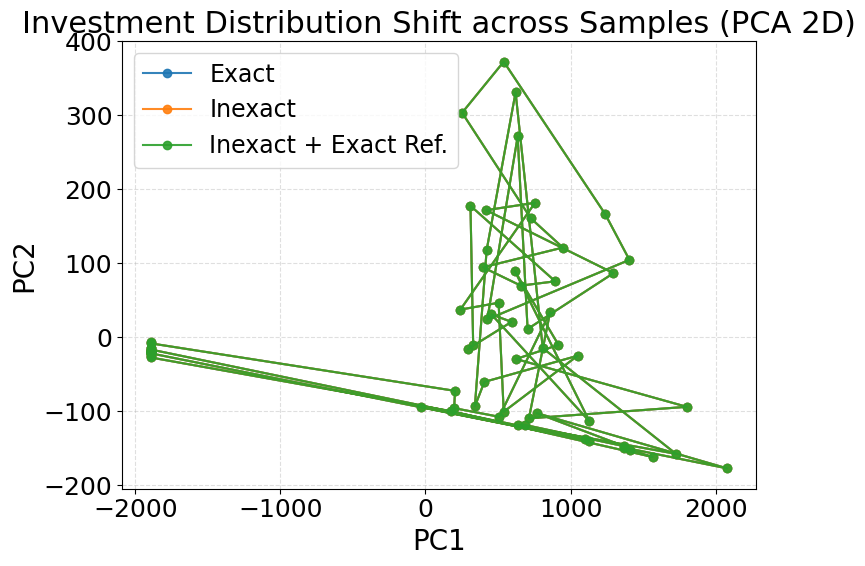

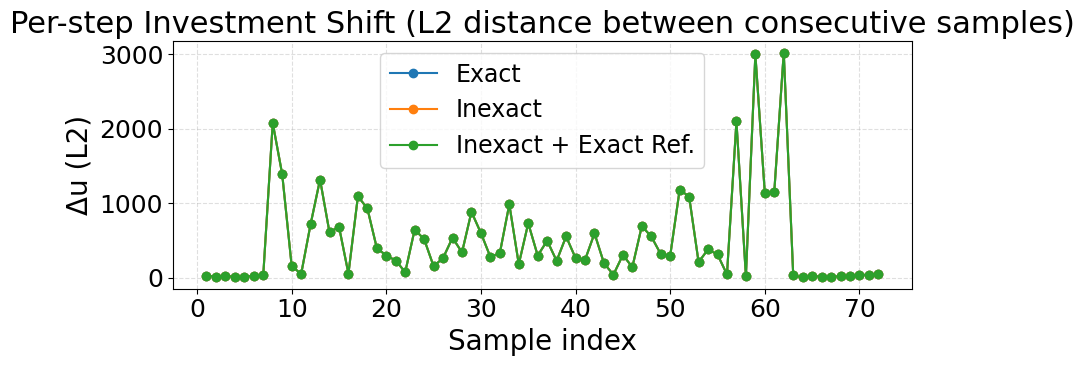

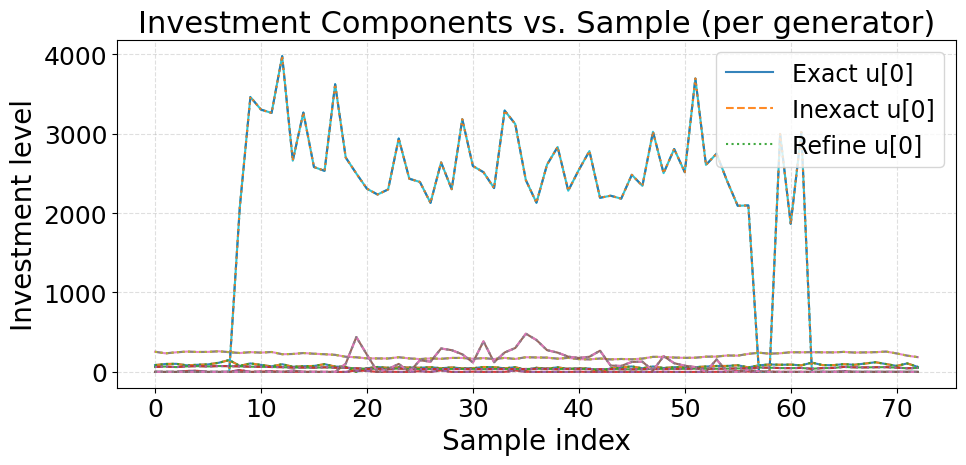

In [32]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# --- paths (edit these to your files) ---
base = Path("3nodes/benders_data")

f_inexact   = base / "experiment_data_sample_duration:120_start_exact:False_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"
f_exact     = base / "experiment_data_sample_duration:120_start_exact:True_exact_refinement:False_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"
f_refine    = base / "experiment_data_sample_duration:120_start_exact:False_exact_refinement:True_run_name:train:0.8_rho:0.0_rhomax:5000_alpha:10.csv"

def load_investments(csv_path):
    df = pd.read_csv(csv_path)
    # keep ordering by sample; if you have multiple repeats, pick one or average later
    # here we keep all rows and add a parsed vector column
    df["u"] = df["investments"].apply(lambda s: np.array(ast.literal_eval(s), dtype=float))
    return df

D_inexact = load_investments(f_inexact)
D_exact   = load_investments(f_exact)
D_refine  = load_investments(f_refine)

# print a slice to check for all three
print(D_inexact[["sample", "repeat", "u"]].head())
print(D_exact[["sample", "repeat", "u"]].head())
print(D_refine[["sample", "repeat", "u"]].head())

# Option: if multiple repeats exist, choose one repeat for a clean trajectory
rep = 0
E = D_exact[D_exact["repeat"]==rep].sort_values("sample").reset_index(drop=True)
I = D_inexact[D_inexact["repeat"]==rep].sort_values("sample").reset_index(drop=True)
R = D_refine[D_refine["repeat"]==rep].sort_values("sample").reset_index(drop=True)

U_exact   = np.stack(E["u"].to_list())   # shape (T, n_g)
U_inexact = np.stack(I["u"].to_list())   # shape (T, n_g)
U_refine  = np.stack(R["u"].to_list())   # shape (T, n_g)



# ---------- PCA trajectory (2D) ----------
allU = np.vstack([U_exact, U_inexact, U_refine])
pca = PCA(n_components=2)
Z   = pca.fit_transform(allU)

T = len(U_exact)  # assuming same T per case
Z_exact, Z_inexact, Z_refine = Z[0:T], Z[T:2*T], Z[2*T:3*T]

plt.figure(figsize=(8,6))
plt.plot(Z_exact[:,0],   Z_exact[:,1],   '-o', label='Exact',   alpha=0.9)
plt.plot(Z_inexact[:,0], Z_inexact[:,1], '-o', label='Inexact', alpha=0.9)
plt.plot(Z_refine[:,0],  Z_refine[:,1],  '-o', label='Inexact + Exact Ref.', alpha=0.9)
plt.title("Investment Distribution Shift across Samples (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True, ls='--', alpha=0.4); plt.legend()
plt.tight_layout()
plt.show()

# ---------- Quantify shift: distance between consecutive samples ----------
def step_distances(U, metric="l2"):
    if metric == "l2":
        d = np.linalg.norm(U[1:] - U[:-1], axis=1)
    elif metric == "cos":
        X = U[1:]; Y = U[:-1]
        d = 1 - np.sum(X*Y, axis=1)/(np.linalg.norm(X,axis=1)*np.linalg.norm(Y,axis=1) + 1e-12)
    return d

dE = step_distances(U_exact,   "l2")
dI = step_distances(U_inexact, "l2")
dR = step_distances(U_refine,  "l2")

plt.figure(figsize=(9,4))
plt.plot(range(1,T), dE, '-o', label='Exact')
plt.plot(range(1,T), dI, '-o', label='Inexact')
plt.plot(range(1,T), dR, '-o', label='Inexact + Exact Ref.')
plt.title("Per-step Investment Shift (L2 distance between consecutive samples)")
plt.xlabel("Sample index"); plt.ylabel("Δu (L2)"); plt.grid(True, ls='--', alpha=0.4); plt.legend()
plt.tight_layout()
plt.show()

# ---------- (Optional) per-dimension evolution ----------
plt.figure(figsize=(10,5))
for j in range(U_exact.shape[1]):
    plt.plot(U_exact[:,j],   '-',  alpha=0.9, label=f'Exact u[{j}]' if j==0 else None)
    plt.plot(U_inexact[:,j], '--', alpha=0.9, label=f'Inexact u[{j}]' if j==0 else None)
    plt.plot(U_refine[:,j],  ':',  alpha=0.9, label=f'Refine u[{j}]' if j==0 else None)
plt.title("Investment Components vs. Sample (per generator)")
plt.xlabel("Sample index"); plt.ylabel("Investment level")
plt.grid(True, ls='--', alpha=0.4); plt.legend()
plt.tight_layout(); plt.show()


In [19]:
! ls

1node
2nodes-1gen
2nodes-2gens
3nodes
ED_NB-G-F_GB2-G2-F2_L3_c0_s0_p0_smp15.pkl
data_analysis.ipynb
tables.ipynb
